In [184]:
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import xgboost as xgb

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [185]:
df_train = pd.read_csv("data/train.csv", low_memory=False, parse_dates=[2])
df_test = pd.read_csv("data/test.csv", low_memory=False, parse_dates=[3])
df_store = pd.read_csv("data/store.csv", low_memory=False)

### Задача прогнозирования продаж (Rossmann store sales)
### https://www.kaggle.com/c/rossmann-store-sales

Необходимо по имеющимся данным спрогнозировать продажи в 1115 магазинах сети Rossmann с горизонтом 6 недель.

##### Структура данных:

Id - идентификатор наблюдения в тестовой выборке;  
Store - идентификатор магазина;  
Sales - продажи за день;  
Customers - количество покупателей за день;  
Open - идентификатор рабочего дня магазина : 0 = закрыт, 1 = открыт;  
StateHoliday - индикатор государственного праздника. a = праздничный день, b = Пасха, c = Рождество, 0 = не праздник;  
SchoolHoliday - открыты ли школы в этот день;  
StoreType - 4 различных типов магазинов;  
Assortment - ассортимент магазина: a = basic, b = extra, c = extended;  
CompetitionDistance - расстояние до ближайшего конкурирующего магазина;  
CompetitionOpenSince[Month/Year] - дата открытия ближайшего конкурента;  
Promo - индикатор промо-акции в день наблюдения;  
Promo2 - участвует ли магазин в возобновляемой рекламной кампании: 0 = нет, 1 = да;  
Promo2Since[Year/Week] - дата старта Promo2;  
PromoInterval - интервал возобновления Promo2 (в месяцах ежегодно);

Набор данных состоит из трех количественных непрерывных признаков (Sales, Customers, CompetitionDistance), причем первые два отсутствуют в тестовом множестве, временных меток (Date, DayOfWeek, CompetitionOpenSince, Promo2Since, PromoInterval), из которых возможно создать количественные признаки. Также имеются 8 категориальных признаков.  

Цель работы - построение предиктивной регрессионной модели, базирующейся на, во-первых, перечесленных признаках, и, возможно, на имеющихся 1115 временных рядах продаж каждого магазина, и способной на их основе предсказывать продажи на 6 недель вперед.

### Разведывательный анализ данных и создание признаков.

Проверка на отсутствующие данные.

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


In [5]:
df_test[df_test["Open"].isna()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,NaN,1,0,0
1335,1336,622,3,2015-09-16,NaN,1,0,0
2191,2192,622,2,2015-09-15,NaN,1,0,0
3047,3048,622,1,2015-09-14,NaN,1,0,0
4759,4760,622,6,2015-09-12,NaN,0,0,0
5615,5616,622,5,2015-09-11,NaN,0,0,0
6471,6472,622,4,2015-09-10,NaN,0,0,0
7327,7328,622,3,2015-09-09,NaN,0,0,0
8183,8184,622,2,2015-09-08,NaN,0,0,0
9039,9040,622,1,2015-09-07,NaN,0,0,0


In [6]:
df_train[df_train["Store"]==622]["Open"].value_counts()

1    784
0    158
Name: Open, dtype: int64

В тренировочном наборе все значения известны. В тестовом пропущены несколько значений признака "Open". Все относятся к магазину №622. Соотношение значений этого признака в известных данных 784/158, кроме того, пропущенные дни относятся к будням, а в некоторых указано наличие промо-акции. По этим причинам, а также из-за требуемой по условиям задания метрики качества (ниже), пропущенные значения заполняются 1.

In [186]:
df_test["Open"] = df_test["Open"].fillna(1)

In [8]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


В данных по магазинам несколько серий с пропущенными значениями. Отсутствующие данные в разделе Promo2 соответствуют неучастию магазина в этих акциях. Также частично незаполненными оказались строки в разделе Competition. Все эти данные кодировались -1 (проверки на первых моделях показали преимущество этого перед заполнением медианным значением).  
Перед этим, даты начала конкуренции и участия магазина в возобновляемой рекламной кампании собираются из отдельных колонок и переводятся в тип int. А также, значения "PromoInterval" разделяются на четыре числовых признака по номерам месяцев.

In [187]:
def competition_date(data):
    if np.isnan(data["CompetitionOpenSinceYear"]):
        return np.nan
    y = int(data["CompetitionOpenSinceYear"])
    m = int(data["CompetitionOpenSinceMonth"])
    return pd.datetime.strptime("{}-{}".format(y, m), "%Y-%m")

df_store["CompetitionSince"] = df_store.apply(competition_date, axis=1)
df_store["CompetitionSinceInt"] = df_store["CompetitionSince"].astype(np.int64)

def promo2_date(data):
    if np.isnan(data["Promo2SinceYear"]):
        return np.nan
    y = int(data["Promo2SinceYear"])
    w = int(data["Promo2SinceWeek"])
    return pd.datetime.strptime("{} {} 1".format(y, w), "%Y %W %w")

df_store["Promo2Since"] = df_store.apply(promo2_date, axis=1)
df_store["Promo2SinceInt"] = df_store["Promo2Since"].astype(np.int64)

In [188]:
month_dict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
             "Jul": 7, "Aug": 8, "Sept": 9, "Oct": 10, "Nov": 11, "Dec": 12}

def make_intervals(data):
    if pd.isnull(data["PromoInterval"]):
        data["PromoInterval1"] = np.nan
        data["PromoInterval2"] = np.nan
        data["PromoInterval3"] = np.nan
        data["PromoInterval4"] = np.nan
    else:
        pi = data["PromoInterval"].split(",")
        data["PromoInterval1"] = month_dict[pi[0]]
        data["PromoInterval2"] = month_dict[pi[1]]
        data["PromoInterval3"] = month_dict[pi[2]]
        data["PromoInterval4"] = month_dict[pi[3]]
    return data

df_store = df_store.apply(make_intervals, axis=1)

df_store.fillna(-1, inplace=True)

В наборе для обучения присутствуют значения продаж, равные 0, в некоторых случаях, когда магазин открыт. Это могут быть ошибки в данных, кроме того, нулевые продажи игнорируются в метрике качества. Эти наблюдения были удалены.

In [189]:
print("Количество нулевых продаж при открытом магазине: {}".format(df_train[(df_train["Sales"]==0) & (df_train["Open"]==1)].shape[0]))
mask = (df_train["Sales"]==0) & (df_train["Open"]==1)
df_train = df_train[~mask]

Количество нулевых продаж при открытом магазине: 54


Распределения числовых признаков являются асимметричными и имеют длинные правые хвосты, что похоже на логнормальное распределение. Для проверки этого они были прологарифмированы, что уменьшило ассиметрию. Далее в моделях используются логарифмы значений продаж в качестве целевой переменной.

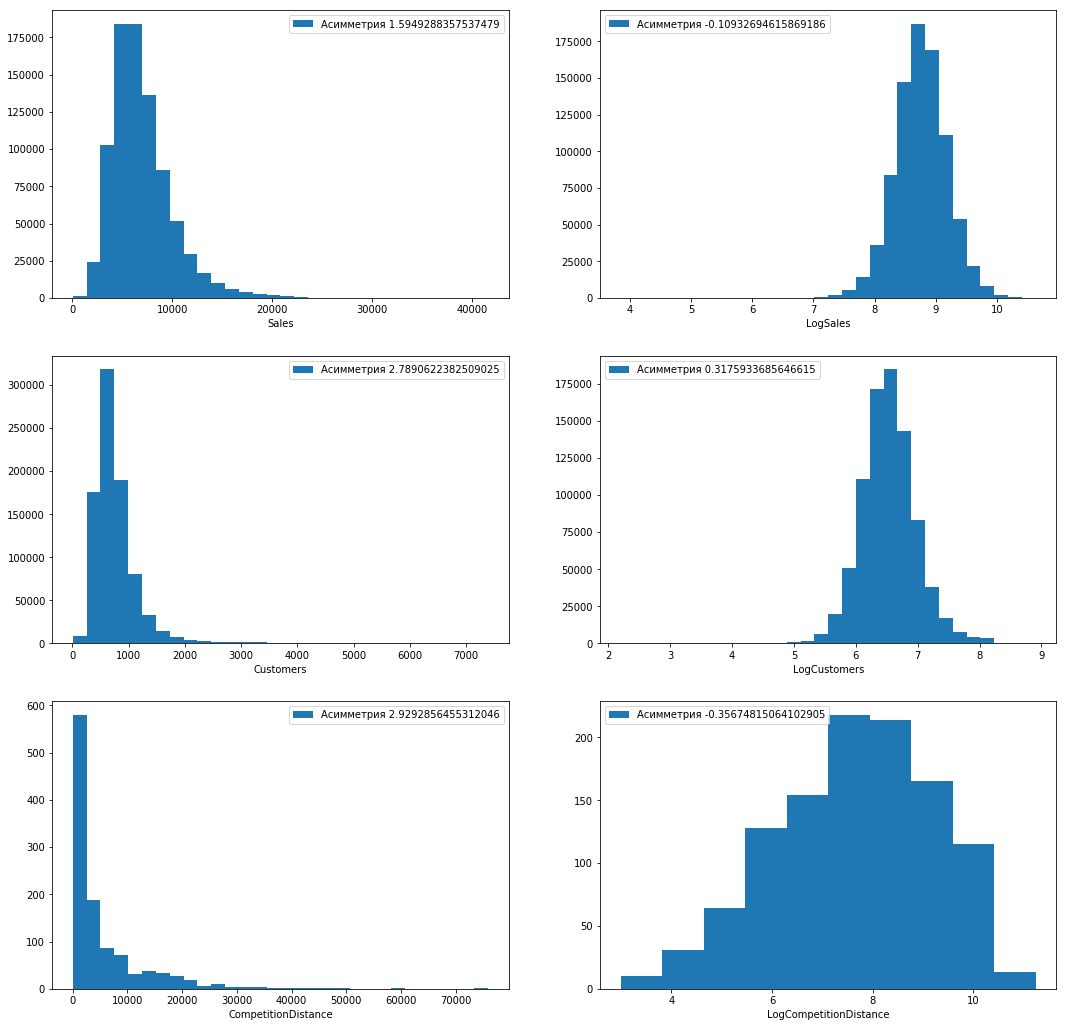

In [190]:
mask_sales = df_train["Sales"]>0
plt.figure(figsize=(18,18))
plt.subplot(3, 2, 1)
plt.hist(df_train.loc[mask_sales, "Sales"], bins=30, label="Асимметрия {}".format(df_train.loc[mask_sales, "Sales"].skew()))
plt.xlabel("Sales")
plt.legend()
plt.subplot(3, 2, 2)
plt.hist(np.log1p(df_train.loc[mask_sales, "Sales"]), bins=30, label="Асимметрия {}".format(np.log1p(df_train.loc[mask_sales, "Sales"]).skew()))
plt.xlabel("LogSales")
plt.legend()
plt.subplot(3, 2, 3)
plt.hist(df_train.loc[mask_sales, "Customers"], bins=30, label="Асимметрия {}".format(df_train.loc[mask_sales, "Customers"].skew()))
plt.xlabel("Customers")
plt.legend()
plt.subplot(3, 2, 4)
plt.hist(np.log1p(df_train.loc[mask_sales, "Customers"]), bins=30, label="Асимметрия {}".format(np.log1p(df_train.loc[mask_sales, "Customers"]).skew()))
plt.xlabel("LogCustomers")
plt.legend()
mask_com = df_store["CompetitionDistance"]>0
plt.subplot(3, 2, 5)
plt.hist(df_store.loc[mask_com, "CompetitionDistance"], bins=30, label="Асимметрия {}".format(df_store.loc[mask_com, "CompetitionDistance"].skew()))
plt.xlabel("CompetitionDistance")
plt.legend()
plt.subplot(3, 2, 6)
plt.hist(np.log(df_store.loc[mask_com, "CompetitionDistance"]), bins=10, label="Асимметрия {}".format(np.log(df_store.loc[mask_com,"CompetitionDistance"]).skew()))
plt.xlabel("LogCompetitionDistance")
plt.legend()
plt.show()

In [191]:
df_train["LogSales"] = np.log1p(df_train["Sales"])
df_train["LogCustomers"] = np.log1p(df_train["Customers"])
df_store.loc[mask_com, "LogCompetitionDistance"] = np.log1p(df_store.loc[mask_com, "CompetitionDistance"])
df_store["LogCompetitionDistance"] = df_store["LogCompetitionDistance"].fillna(-1)

Создание списка признаков. Все 4 колонки месячных интервалов "Promo2" коррелированы, достаточно одного. И сам "Promo2" уже избыточен.

In [192]:
features_log = ["Store", "Promo", "StateHoliday", "SchoolHoliday", "StoreType", 
                   "Assortment", "LogCompetitionDistance", "CompetitionSinceInt", "PromoInterval1", "Promo2SinceInt"]

Категориальный признак "StateHoliday" необходимо закодировать числовыми значениями.

In [193]:
stahol = {"0": 0, "a": 1, "b": 2, "c": 3}
df_train["StateHoliday"].replace(stahol, inplace=True)
df_test["StateHoliday"].replace(stahol, inplace=True)

Линейные взаимосвязи между переменными. Очень тесная, что не удивительно, связь продаж с количеством посетителей. Однако, этот признак отсутствует в тестовом наборе. В следствие чего, появляется необходимость создавать на его основе новые признаки, которые возможно использовать в "будущем". Также есть некотороя корреляция с Promo-акциями и праздниками.

In [194]:
df_train[["LogSales", "LogCustomers", "Promo", "SchoolHoliday", "StateHoliday"]].corr()

,LogSales,LogCustomers,Promo,SchoolHoliday,StateHoliday
LogSales,1.000000,0.996252,0.337165,0.090437,-0.338401
LogCustomers,0.996252,1.000000,0.328036,0.090439,-0.335721
Promo,0.337165,0.328036,1.000000,0.067490,-0.024157
SchoolHoliday,0.090437,0.090439,0.067490,1.000000,0.196432
StateHoliday,-0.338401,-0.335721,-0.024157,0.196432,1.000000


Создание дополнительных признаков для магазинов. Для этого используются агрегированные показатели средних продаж по магазинам, среднее число покупателей, средний размер чека (продажи/покупатели). Подобным образом обобщаются продажи по дню недели и, более детализировано, средние продажи по каждому магазину по дням недели.

In [195]:
# Средние по магазинам
stores = df_train.groupby("Store")

def map_sales_means(data):
    data["Sales_mean"] = data["Store"].map(stores["Sales"].mean())
    data["Customers_mean"] = data["Store"].map(stores["Customers"].mean())
    data["SPC_mean"] = data["Store"].map(stores["Sales"].mean()/stores["Customers"].mean())    
    data["LogSales_mean"] = data["Store"].map(stores["LogSales"].mean())
    data["LogCustomers_mean"] = data["Store"].map(stores["LogCustomers"].mean())
    data["LogSPC_mean"] = data["Store"].map(stores["LogSales"].mean()/stores["LogCustomers"].mean())    

map_sales_means(df_train)
map_sales_means(df_test)

# Средние по дням недели
weekdays = df_train[df_train["Sales"]>0].groupby(["DayOfWeek"])

df_train["Weekdays_mean"] = df_train["DayOfWeek"].map(weekdays["Sales"].mean())
df_test["Weekdays_mean"] = df_test["DayOfWeek"].map(weekdays["Sales"].mean())
df_train["LogWeekdays_mean"] = df_train["DayOfWeek"].map(weekdays["LogSales"].mean())
df_test["LogWeekdays_mean"] = df_test["DayOfWeek"].map(weekdays["LogSales"].mean())

# Средние по дням недели по магазинам
wd_stores = df_train[df_train["Sales"]>0].groupby(["Store", "DayOfWeek"])
wd_stores_s = wd_stores["Sales"].mean()
wd_stores_log = wd_stores["LogSales"].mean()

def map_wd_mean(data):
    for s in data["Store"].unique():
        for wd in data["DayOfWeek"].unique():
            if wd in wd_stores_s[s]:
                data.loc[(data["Store"]==s) & (data["DayOfWeek"]==wd), "Store_WD_mean"] = wd_stores_s[s, wd]        
                data.loc[(data["Store"]==s) & (data["DayOfWeek"]==wd), "LogStore_WD_mean"] = wd_stores_log[s, wd]
                
map_wd_mean(df_train)
map_wd_mean(df_test)

df_train["Store_WD_mean"] = df_train["Store_WD_mean"].fillna(0)
df_train["LogStore_WD_mean"] = df_train["LogStore_WD_mean"].fillna(0)
df_test["Store_WD_mean"] = df_test["Store_WD_mean"].fillna(0)
df_test["LogStore_WD_mean"] = df_test["LogStore_WD_mean"].fillna(0)

features_log += ["LogSales_mean", "LogCustomers_mean", "LogSPC_mean", "LogWeekdays_mean", "LogStore_WD_mean"]

Взаимосвязи новых признаков с продажами. Наибольшую линейную зависимость видно с последним созданным признаком.

In [19]:
df_train[["LogSales"] + ["LogSales_mean", "LogCustomers_mean", "LogSPC_mean", "LogWeekdays_mean", "LogStore_WD_mean"]].corr()

,LogSales,LogSales_mean,LogCustomers_mean,LogSPC_mean,LogWeekdays_mean,LogStore_WD_mean
LogSales,1.000000,0.112888,0.102960,-0.047684,0.113292,0.883534
LogSales_mean,0.112888,1.000000,0.912055,-0.422399,0.000014,0.115161
LogCustomers_mean,0.102960,0.912055,1.000000,-0.753343,0.000019,0.105042
LogSPC_mean,-0.047684,-0.422399,-0.753343,1.000000,-0.000019,-0.049068
LogWeekdays_mean,0.113292,0.000014,0.000019,-0.000019,1.000000,0.161529
LogStore_WD_mean,0.883534,0.115161,0.105042,-0.049068,0.161529,1.000000


В распределении продаж по типу магазина видно, что только "b" имеет сильное влияние. Средние по ассортименту отличаются на 10-20%. Эти категориальные признаки закодированы по возрастанию.

In [196]:
stotyp = {"a": 1, "b": 3, "c": 2, "d": 0}
assort = {"a": 0, "b": 2, "c": 1}
df_store["StoreType"].replace(stotyp, inplace=True)
df_store["Assortment"].replace(assort, inplace=True)

# Объединение данных.
df_train = pd.merge(df_train, df_store, how='left', on=['Store'])
df_test = pd.merge(df_test, df_store, how='left', on=['Store'])

In [24]:
df_train[df_train["Sales"]>0].groupby("StoreType")["Sales"].mean()

StoreType
0     6822.300064
1     6925.697986
2     6933.126425
3    10233.380141
Name: Sales, dtype: float64

In [25]:
df_train[df_train["Sales"]>0].groupby("Assortment")["Sales"].mean()

Assortment
0    6621.523057
1    7300.843547
2    8642.503594
Name: Sales, dtype: float64

Создание дополнительных числовых признаков из дат, таких как номер недели, месяца, года и др. Были протестированы и другие признаки, например, является ли текущий месяц началом "Promo2", количество дней до/после праздников или "Promo". Они были исключены, поскольку увеличивали ошибку модели.

In [197]:
df_train["DateOrd"] = df_train["Date"].apply(lambda x: x.toordinal() if not pd.isnull(x) else np.nan)
df_test["DateOrd"] = df_test["Date"].apply(lambda x: x.toordinal() if not pd.isnull(x) else np.nan)

df_train["DayNumber"] = df_train["DateOrd"]-734869
df_test["DayNumber"] = df_test["DateOrd"]-734869

df_train["DayOfMonth"] = pd.Index(df_train["Date"]).day
df_train["DayOfYear"] = pd.Index(df_train["Date"]).dayofyear
df_train["WeekOfYear"] = pd.Index(df_train["Date"]).week
df_train["MonthNumber"] = pd.Index(df_train["Date"]).month
df_train["QuarterNumber"] = pd.Index(df_train["Date"]).quarter
df_train["YearNumber"] = pd.Index(df_train["Date"]).year

df_test["DayOfMonth"] = pd.Index(df_test["Date"]).day
df_test["DayOfYear"] = pd.Index(df_test["Date"]).dayofyear
df_test["WeekOfYear"] = pd.Index(df_test["Date"]).week
df_test["MonthNumber"] = pd.Index(df_test["Date"]).month
df_test["QuarterNumber"] = pd.Index(df_test["Date"]).quarter
df_test["YearNumber"] = pd.Index(df_test["Date"]).year

features_log += ["DayOfWeek", "DayOfMonth", "DayOfYear", "WeekOfYear", "YearNumber", "MonthNumber"]

### Исследование временных рядов продаж.

Обращение к временным рядам продаж позволяет увидеть некоторую периодичность, а в отдельных магазинах наблюдаются тренды. Производится выделение этих компонентов временного ряда. Тренды аппроксимировались квадратичными и кубическими полиномами при помощи ridge - регрессии. В дальнейшем, экстраполированные выходы этих моделей использовались как новые признаки. Циклические колебания выделялись через разложение Фурье рядов с удаленным трендом. Эти значения не использовались для прогнозирования, из-за высокого риска переобучения. Они применяются в дальнейшем для работы с выбросами.

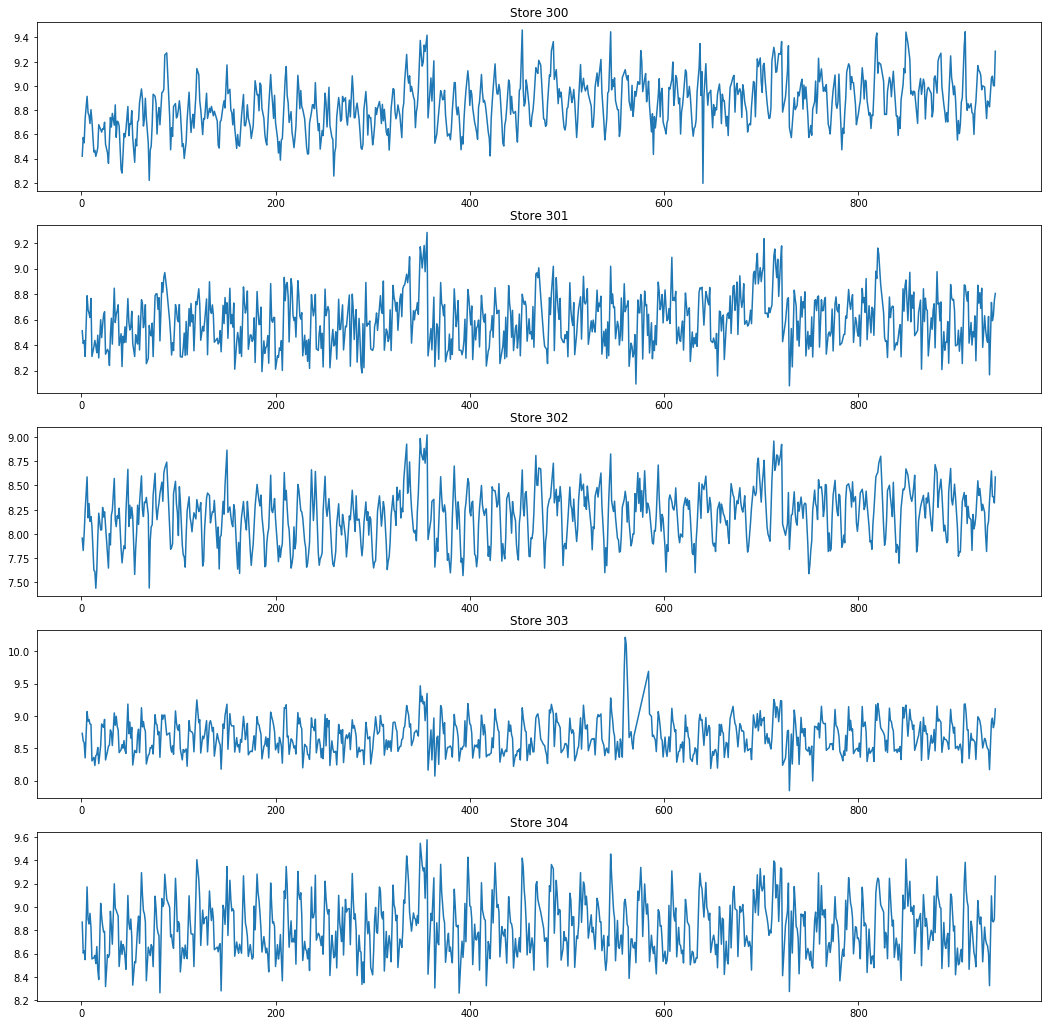

In [103]:
fig, ax = plt.subplots(5, 1, figsize=(18, 18))

st = 300
for i in range(st, st+5):
    mask = df_timeseries[i].values > 0
    plot_vals = df_timeseries.loc[mask, i]
    ax[i-st].plot(plot_vals)    
    ax[i-st].set_title("Store {}".format(i))    
    
plt.show()

In [198]:
# Создается сводная таблица продаж по магазинам на каждую дату
df_timeseries = df_train[["DateOrd", "Store", "LogSales"]]
df_timeseries = pd.pivot_table(df_timeseries, values="LogSales", index="DateOrd", columns="Store").copy()
df_timeseries.fillna(df_timeseries[df_timeseries>0].mean(), inplace=True)
date_ord0 = df_timeseries.index[0]
df_timeseries.index = df_timeseries.index - date_ord0

# Расчет трендов
reg_poly = RidgeCV()
def get_logtrends(store): 
    mask = df_timeseries[store].values > 0
    X_poly = df_timeseries[mask].index.values.reshape(-1, 1).astype(np.float64)
    scaler_time = MinMaxScaler()
    X_poly = scaler_time.fit_transform(X_poly)
    X_poly2 = np.c_[X_poly, X_poly**2]
    X_poly3 = np.c_[X_poly, X_poly**2, X_poly**3]    
    y_poly = df_timeseries.loc[mask, store].values    
        
    X_full = np.concatenate((sorted(df_train["DateOrd"].unique()), sorted(df_test["DateOrd"].unique()))) - date_ord0
    X_full = X_full.reshape(-1, 1).astype(np.float64)
    X_full = scaler_time.transform(X_full)
    X_full2 = np.c_[X_full, X_full**2]
    X_full3 = np.c_[X_full, X_full**2, X_full**3]
    
    reg_poly.fit(X_poly2, y_poly)
    trend2 = reg_poly.predict(X_full2)
    reg_poly.fit(X_poly3, y_poly)
    trend3 = reg_poly.predict(X_full3)
    return trend2, trend3

df_timeseries_test = pd.DataFrame(index=sorted(df_test["DateOrd"].unique()) - date_ord0)

Графики выделенных трендов. В некоторых магазинах отсутствуют данные продаж за интервал, они были заменены на средние.

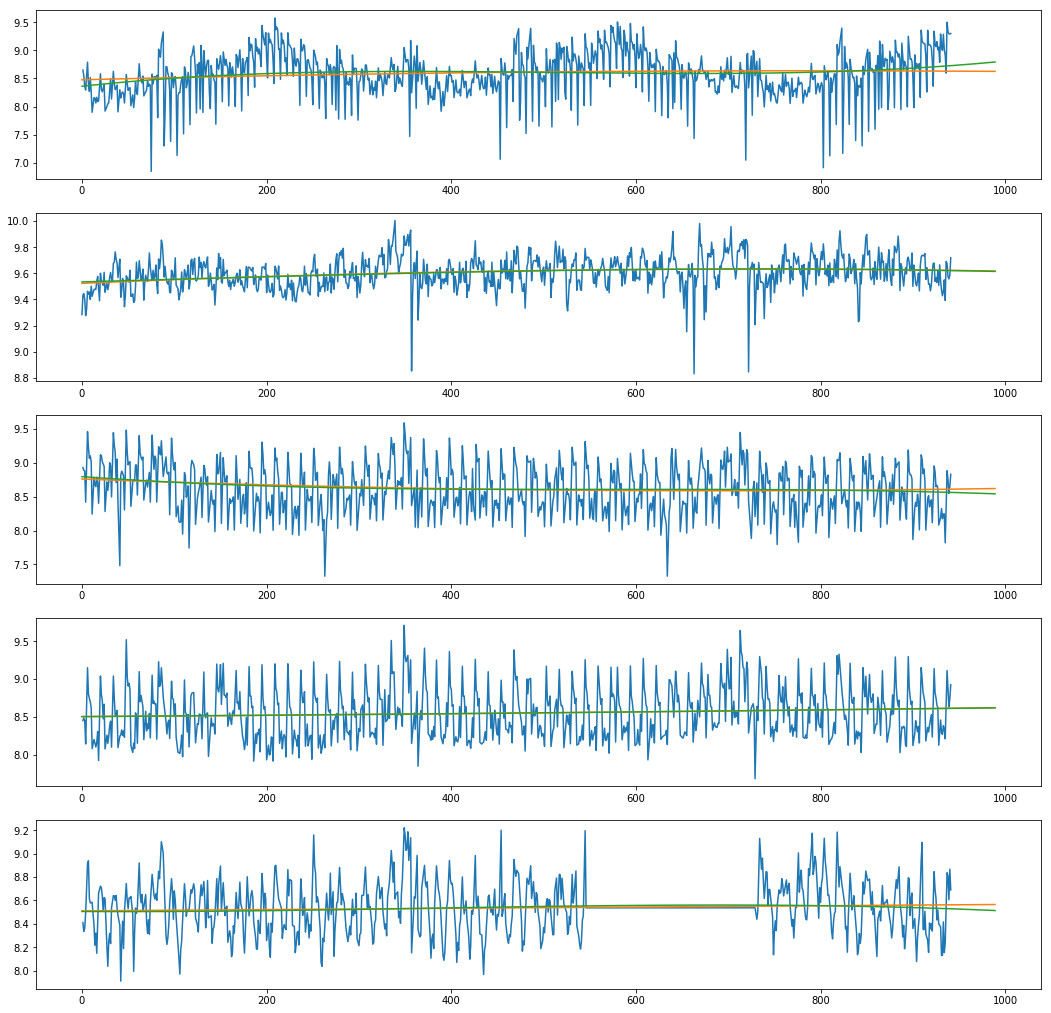

In [105]:
fig, ax = plt.subplots(5, 1, figsize=(18, 18))

st = 732
for i in range(st, st+5):
    mask = df_timeseries[i].values > 0
    plot_vals = df_timeseries.loc[mask, i]
    ax[i-st].plot(plot_vals)
    ax[i-st].plot(get_logtrends(i)[0])
    ax[i-st].plot(get_logtrends(i)[1])  
    ax[i-st].set_title("Store {}".format(i))    
    
plt.show()

In [199]:
for i in range(1, 1116):
    trend2, trend3 = get_logtrends(i)
    df_timeseries["LogTrend2_{}".format(i)] = trend2[:942]    
    df_timeseries_test["LogTrend2_{}".format(i)] = trend2[942:]
    df_timeseries["LogTrend3_{}".format(i)] = trend3[:942]    
    df_timeseries_test["LogTrend3_{}".format(i)] = trend3[942:]
    df_timeseries["Detrended2_{}".format(i)] = (df_timeseries[i] - df_timeseries["LogTrend2_{}".format(i)])    
    df_timeseries["Detrended3_{}".format(i)] = (df_timeseries[i] - df_timeseries["LogTrend3_{}".format(i)]) 

In [111]:
rmses2 = []
rmses3 = []

for i in range(1, 1116):     
    mask = df_timeseries[i].values > 0
    true = df_timeseries[mask][i].values
    trend2 = df_timeseries[mask]["LogTrend2_{}".format(i)].values
    trend3 = df_timeseries[mask]["LogTrend3_{}".format(i)].values    
    rmses2.append(np.sqrt(mean_squared_error(y_true=true, y_pred=trend2)))
    rmses3.append(np.sqrt(mean_squared_error(y_true=true, y_pred=trend3)))
    
print("RMSE крадратичного тренда: {0: .4f}".format(np.mean(rmses2)))
print("RMSE кубического тренда: {0: .4f}".format(np.mean(rmses3)))

RMSE крадратичного тренда:  0.2579
RMSE кубического тренда:  0.2576


Средние RMSE при разных степенях полиномов отличаются только в четвертом знаке после запятой.

Проверка на стационарность рядов с удаленным трендом при помощи теста Дики-Фуллера. При использовании кубического тренда остается три магазина с нестационарными рядами. Ниже представлены графики этих рядов, на которых видны долгосрочные периодические колебания, а в двух последних наблюдаются аномальные значения, возможно, нижние выбросы.

In [124]:
results2 = {}
results3 = {}

for i in range(1, 1116):  
    mask = df_timeseries[i].values > 0
    af_y = df_timeseries.loc[mask, "Detrended2_{}".format(i)].values        
    test = sm.tsa.adfuller(af_y)
    if test[1] > 0.05:
        results2[i] = test[1]    
    af_y = df_timeseries.loc[mask, "Detrended3_{}".format(i)].values        
    test = sm.tsa.adfuller(af_y)
    if test[1] > 0.05:
        results3[i] = test[1] 
print("Номера магазинов с нестационарными рядами (квадратичный тренд): {}".format([i for i in results2.keys()]))
print("Номера магазинов с нестационарными рядами (кубический тренд): {}".format([i for i in results3.keys()]))

Номера магазинов с нестационарными рядами (квадратичный тренд): [530, 578, 732, 931]
Номера магазинов с нестационарными рядами (кубический тренд): [530, 732, 931]


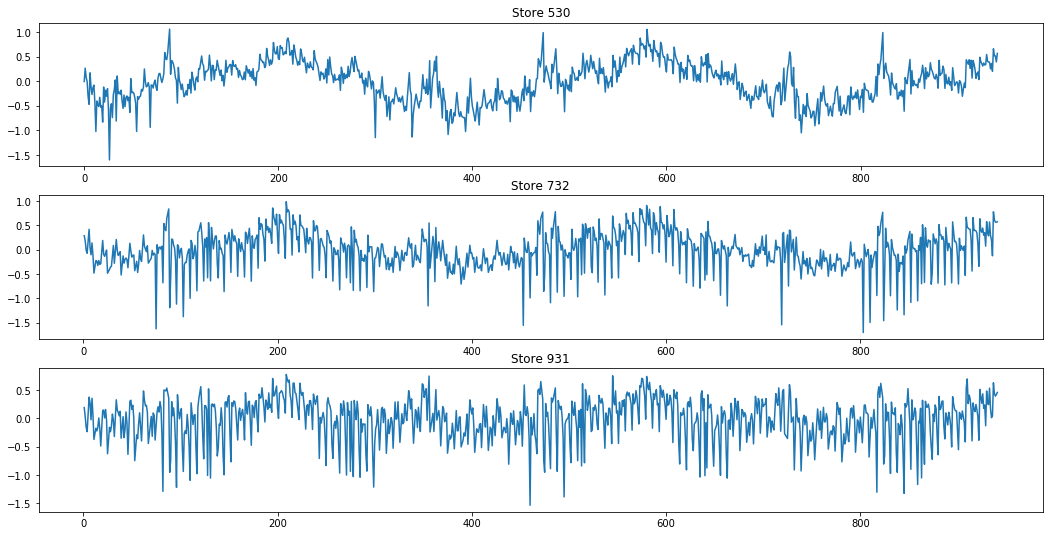

In [125]:
fig, ax = plt.subplots(3, 1, figsize=(18, 9))
i = 0
for s in results3.keys():
    ax[i].plot(df_timeseries.loc[df_timeseries[s] > 0, "Detrended3_{}".format(s)])
    ax[i].set_title("Store {}".format(s))    
    i += 1

Выделение периодических колебаний из рядов с удаленными трендами. Далее 2/3 самых важных частот используются для замены выбросов.

In [200]:
# Вычисляет ряды Фурье
def get_seasonal(store, freq_fraction=0.66): 
    mask = df_timeseries[store].values > 0
    w_detrended = df_timeseries.loc[mask, "Detrended3_{}".format(store)].values 
    length = w_detrended.shape[0]
    t = np.arange(length)
    
    s = np.fft.fft(w_detrended)
    freq = np.fft.fftfreq(length)
    inds_freq = np.arange(length)
    inds_freq = sorted(inds_freq, key = lambda i: np.absolute(freq[i]))    
    
    t = np.arange(length)
    seasonal = np.zeros(length)
    for i in inds_freq[:1 + int(length*freq_fraction)]:
        amplitude = np.absolute(s[i]) / length
        phase = np.angle(s[i])
        seasonal += amplitude * np.cos(2 * np.pi * freq[i] * t + phase)    

    return seasonal    

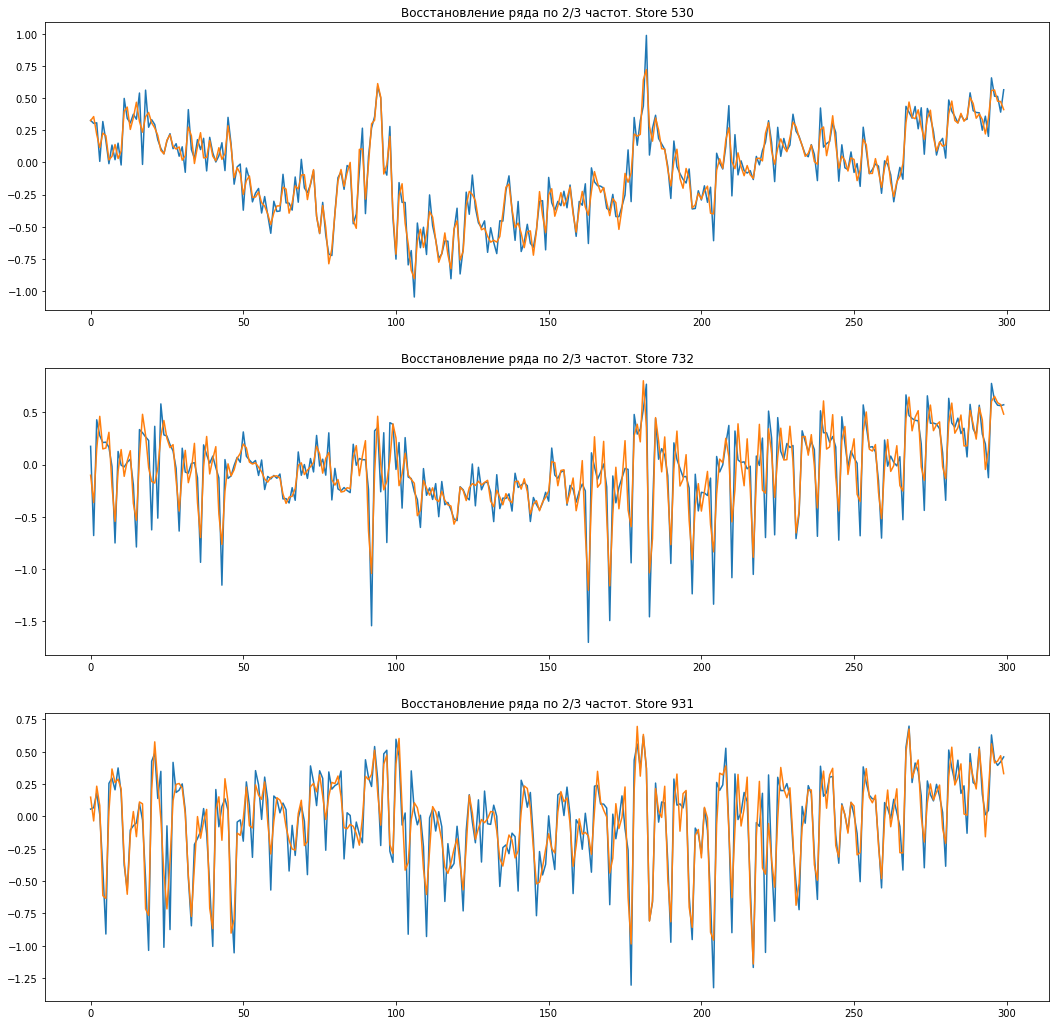

In [128]:
fig, ax = plt.subplots(3, 1, figsize=(18, 18))
i = 0
for s in results3.keys():
    ax[i].plot(df_timeseries.loc[df_timeseries[s]>0, "Detrended3_{}".format(s)].values[-300:])
    ax[i].plot(get_seasonal(s)[-300:])
    ax[i].set_title("Восстановление ряда по 2/3 частот. Store {}".format(s))    
    i += 1

In [201]:
for i in range(1, 1116):    
    seasonal = get_seasonal(i)
    mask = df_timeseries[i].values > 0
    df_timeseries.loc[mask, "Seasonal_{}".format(i)] = seasonal 
    df_timeseries.loc[mask, "Trend_Season_{}".format(i)] = df_timeseries.loc[mask, "LogTrend3_{}".format(i)] + \
                                                    df_timeseries.loc[mask, "Seasonal_{}".format(i)]

Перемещение созданных признаков в исходные таблицы.

In [202]:
def move_trends(source, target):
    for i in target["Store"].unique():
        inds_notnan = target.loc[target["Store"]==i]["DateOrd"].values
        target.loc[((target["Store"]==i) & (target["DateOrd"].isin(inds_notnan))), "LogTrend2"] = \
            source.loc[inds_notnan-date_ord0, "LogTrend2_{}".format(i)].values
        target.loc[((target["Store"]==i) & (target["DateOrd"].isin(inds_notnan))), "LogTrend3"] = \
            source.loc[inds_notnan-date_ord0, "LogTrend3_{}".format(i)].values        
        
move_trends(df_timeseries, df_train)
move_trends(df_timeseries_test, df_test)

for i in df_train["Store"].unique():
    inds_notnan = df_train.loc[df_train["Store"]==i]["DateOrd"].values
    df_train.loc[((df_train["Store"]==i) & (df_train["DateOrd"].isin(inds_notnan))), "Trend_Season"] = \
        df_timeseries.loc[inds_notnan-date_ord0, "Trend_Season_{}".format(i)].values
    
features_log += ["LogTrend2"]

Поиск выбросов. Для этого используется межквартильное расстояние. Выбросом назначается элемент, выходящий за пределы 1.5 IQR сверху, либо 1.75 IQR снизу (из-за более далеких выбросов вверх, иногда, при 1.5 IQR, нижними назначалась вся граница диапазона колебаний). На графиках показаны несколько магазинов с назначенными выбросами.

In [203]:
def get_outliers(data):    
    q75 = data.quantile(0.75)
    q25 = data.quantile(0.25)
    iqr =  q75 - q25
    out_high = q75 + 1.5*iqr
    out_low = q25 - 1.75*iqr
    return ((data > out_high) | (data < out_low))

for i in df_train["Store"].unique():
    df_train.loc[(df_train["Store"]==i) & (df_train["Sales"]>0), "Outlier"] = \
        get_outliers(df_train.loc[(df_train["Store"]==i) & (df_train["Sales"]>0), "LogSales"])

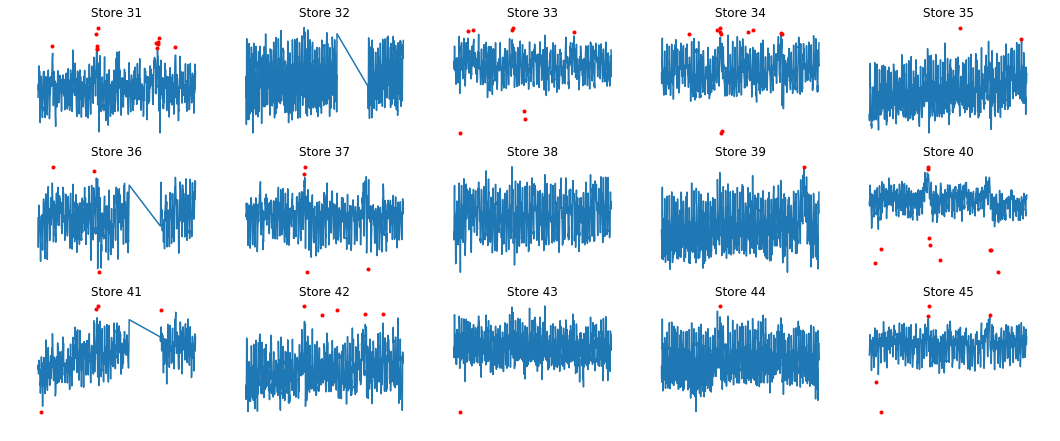

In [136]:
num = 15
st = 31
plt.figure(figsize=(18,38))
for i in range(st,num+st):
    store = i
    
    X1 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == False)]["Date"]
    y1 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == False)]["LogSales"]    
    X2 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == True)]["Date"]
    y2 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == True)]["LogSales"]    
    
    plt.subplot(15,5,i-st+1)
    plt.plot(X1, y1, '-')
    plt.plot(X2, y2, 'r.')
    plt.title("Store {}".format(i))
    plt.axis('off')

Замена выбросов значениями, полученными при объединении кубического тренда и рассчитанными периодическими колебаниями. На графиках видно смещение выбросов к основному диапазону изменения продаж.

In [204]:
df_train.loc[:, "LogSales_Outliers"] = df_train["LogSales"]
df_train.loc[df_train['Outlier'] == True, "LogSales"] = \
    df_train.loc[df_train['Outlier'] == True, "Trend_Season"]

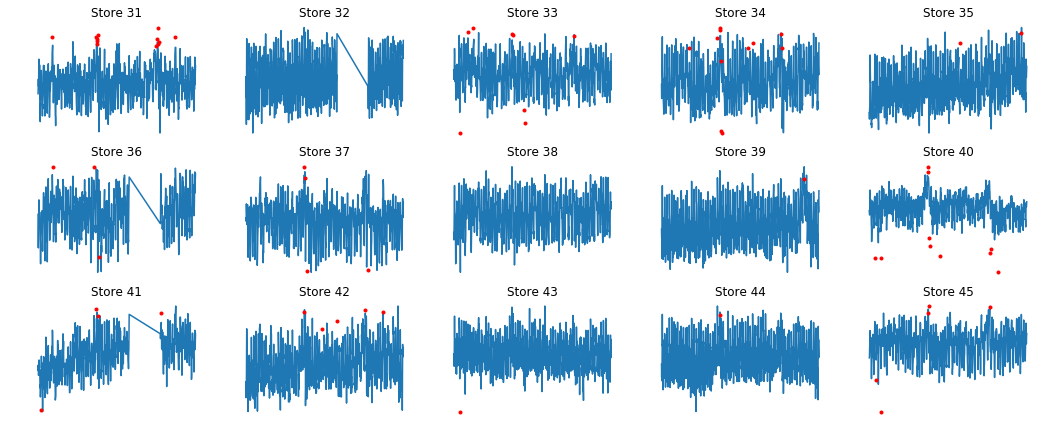

In [138]:
num = 15
st = 31
plt.figure(figsize=(18,38))
for i in range(st,num+st):
    store = i
    
    X1 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == False)]["Date"]
    y1 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == False)]["LogSales"]    
    X2 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == True)]["Date"]
    y2 = df_train.loc[(df_train["Store"] == store) & (df_train["Open"] == 1) & (df_train["Outlier"] == True)]["LogSales"]    
    
    plt.subplot(15,5,i-st+1)
    plt.plot(X1, y1, '-')
    plt.plot(X2, y2, 'r.')
    plt.title("Store {}".format(i))
    plt.axis('off')

### Построение моделей.

Для получения итогового результата используются ансамбли RandomForest и XGBoost. Они обучаются на созданных признаках, а также выходах трендовых регрессионных моделей по каждому магазину. Для подбора гиперпараметров применяется GridSearchCV. Поскольку набор данных представляет собой совокупность временных рядов, при кросс-валидации используется специальный генератор выборок TimeSeriesSplit, создающий постепенно расширяющиеся во времени тренировочные наборы и сдвигаемые в будущее тестовые. Результаты оценивались по заданной условиями задачи метрике RMSPE, вычисляющей процентное отклонение предсказанных значений от истинных:

$RMSPE = \sqrt{\frac{1}{n}\sum_{i=1}^n(\frac{y_i - \hat{y_i}}{y_i})^2}$,

где y - истинное значение, $\hat{y}$ - предсказанное, n - количество наблюдений. При этом, те наблюдения, где продажи были равны нулю, игнорируются.

In [205]:
# Функция ошибки
def rmspe(data, y_pred):
    y_true = data["Sales"]
    y_pred = y_pred[y_true!=0]
    y_true = y_true[y_true!=0]
    return np.sqrt(np.mean(((y_true - y_pred) / y_true)**2))

# RMSPE для GridSearchCV
def _score_rmspe(estimator, X, y):    
    y_pred = estimator.predict(X)    
    y = np.expm1(y)
    y_pred = np.expm1(y_pred)
    rmspe = np.sqrt(np.mean(((y - y_pred) / y)**2))
    return -rmspe

# RMSPE для XGBoost
def rmspe_metric_xgb(preds, train_data):
    y_true = train_data.get_label()
    y_pred = preds[y_true!=0]
    y_true = y_true[y_true!=0]
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)
    return "rmspe", np.sqrt(np.mean(((y_true - y_pred) / y_true)**2))

# Создает .csv для отправки в kaggle
def make_submission(y_hat, Name="test_submission.csv"):
    temp = df_test.copy()
    temp["Sales"] = y_hat
    temp.sort_index(inplace=True)
    temp = temp[["Id", "Sales"]]
    temp.to_csv(Name, index=False)

В качестве базового сабмита использовался выход простой Ridge регрессии на выбранных признаках. Результат в Kaggle - Private RMSPE: 0.18892, Public: 0.16580 (Public считается по ближайшим двум неделям, private - по оставшимся четырем).

In [206]:
X_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1][features_log].values
y_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1]["LogSales"].values

splitter = TimeSeriesSplit(n_splits=3).split(X_cv)

reg = RidgeCV(alphas=(0.001, 0.01, 0.1, 1.0, 10.0, 100), cv=splitter, scoring=_score_rmspe)
X_train = df_train.loc[df_train["Open"]==1, features_log].values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
y_train = df_train.loc[df_train["Open"]==1, "LogSales"].values
reg.fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(rmspe(df_train[df_train["Open"]==1], np.expm1(reg.predict(X_train))))

X_test = scaler.transform(df_test[features_log].values)
y_hat_ridge = np.expm1(reg.predict(X_test))

make_submission(y_hat_ridge)

0.8415703062150213
0.22977941629169676


Поиск гиперпараметров RandomForest. Произведен итеративный подбор параметров. Первым было отобрано количество деревьев и параметры выборки (bootstrap и max_features), затем параметры самих деревьев (глубины и создания ветвей).

In [66]:
model = RandomForestRegressor(n_jobs=6, verbose=0, random_state=42)

param_grid = {"n_estimators" : [100], #[30, 100, 200],
              "bootstrap": [True], #[True, False],
              "max_features": ["sqrt"], #[None, "sqrt", "log2"],
              "max_depth": [None], #[6, 9, 15, None]
              "min_samples_split": [5], # [2, 5, 10],
              "min_samples_leaf": [2], #[1, 2, 4, 50],
              "max_leaf_nodes": [None], #[None, 2, 10, 50],
              "min_weight_fraction_leaf": [0.0] #[0.0, 0.2, 0.4]
             }

X_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1][features_log].values
y_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1]["LogSales"].values

splitter = TimeSeriesSplit(n_splits=3).split(X_cv)
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring=_score_rmspe, cv=splitter, verbose=3)
gs.fit(X_cv, y_cv)
gs.grid_scores_

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100, score=-0.1727819668901966, total=   9.5s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100, score=-0.12506922314419588, total=  22.1s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   35.0s remaining:    0.0s


[CV]  bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=100, score=-0.13527701808865533, total=  35.7s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=200 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=200, score=-0.17345647250401242, total=  18.3s
[CV] bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=200 
[CV]  bootstrap=True, max_depth=None, max_features=sqrt, max_leaf_nodes=None, min_samples_leaf=2, min_samples_split=5, min_weight_fraction_leaf=0.0, n_estimators=200, score=-0.12473804057402453, total=  43.6s
[CV] bootstrap=True, max_depth=None, max_

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.7min finished
D:\Programs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.14438, std: 0.02051, params: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100},
 mean: -0.14443, std: 0.02095, params: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200}]

In [67]:
gs.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100}

In [207]:
def apply_rf(features):
    X_train = df_train.loc[df_train["Open"] == 1][features]
    y_train = df_train.loc[df_train["Open"] == 1][["LogSales"]]
    
    reg_rf = RandomForestRegressor(n_estimators=100, n_jobs=6, max_features="sqrt", max_depth=None, 
                                   min_samples_leaf=2, min_samples_split=5, verbose=1)
    reg_rf.fit(X_train, y_train)    
    return reg_rf

def predict_rf(features):
    X_test = df_test[features]    
    return np.expm1(reg_rf.predict(X_test))

In [208]:
reg_rf = apply_rf(features_log)
y_hat_rf = predict_rf(features_log)
make_submission(y_hat_rf, "submission_RF.csv")

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   19.9s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:   49.0s finished
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.2s finished


Результат модели: Private RMSPE: 0.12134, Public: 0.11052. Ниже показан график важности признаков. Как видно, важнейшие роли играют агрегированные показатели и вычисленный тренд.

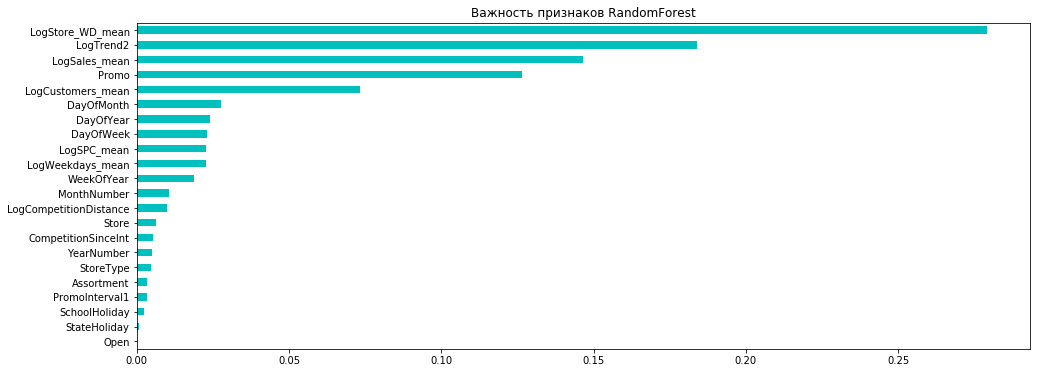

In [155]:
feat_importances = pd.Series(reg_rf.feature_importances_, index=features_log)
plt.figure(figsize=(16, 6))
feat_importances.sort_values().plot(kind="barh", color="c")
plt.title("Важность признаков RandomForest")
plt.show()

Поиск гиперпараметров для XGBoost. Сначала подбиралось количество деревьев (boost_rounds) через кросс-валидатор библиотеки XGBoost. Их число выбрано 1000, после чего ошибка на валидации практически перестает снижаться, в отличие от ошибки на обучении (график), что может привести к переобучению.

In [157]:
X_train = df_train.loc[df_train["Open"] == 1][features_log]
y_train = df_train.loc[df_train["Open"] == 1][["LogSales"]]

dtrain = xgb.DMatrix(X_train, y_train)
num_round = 10000
    
param = {"max_depth": 6,
        "eta": 0.1,
        "subsample": 1,
        "colsample_bytree": 1,
        "silent": 1, 
        "objective": "reg:linear",
        "nthread": 6,
        "seed": 42}

cv_xgb = xgb.cv(param, dtrain, num_round, nfold=3, feval=rmspe_metric_xgb, verbose_eval=250, early_stopping_rounds=50)

[0]	train-rmse:5.79038+0.00032645	train-rmspe:0.996925+9.42809e-07	test-rmse:5.79036+0.000750663	test-rmspe:0.996926+2.35702e-06
[250]	train-rmse:0.0934177+0.000180082	train-rmspe:0.100418+0.00127014	test-rmse:0.0976787+0.000387871	test-rmspe:0.10735+0.00331691
[500]	train-rmse:0.085737+0.000218133	train-rmspe:0.0906833+0.000620679	test-rmse:0.092962+0.000419335	test-rmspe:0.1025+0.00319473
[750]	train-rmse:0.0812613+0.000146165	train-rmspe:0.0853897+0.000511336	test-rmse:0.0909723+0.000305353	test-rmspe:0.100462+0.00313993
[1000]	train-rmse:0.0778327+0.000176864	train-rmspe:0.0812353+0.000441879	test-rmse:0.0898153+0.000300779	test-rmspe:0.0993533+0.00315883
[1250]	train-rmse:0.075099+0.000221221	train-rmspe:0.077931+0.00038576	test-rmse:0.089113+0.000302458	test-rmspe:0.098749+0.00317958
[1500]	train-rmse:0.072763+0.000225785	train-rmspe:0.075265+0.000352542	test-rmse:0.0886443+0.000287576	test-rmspe:0.0983583+0.00316497
[1750]	train-rmse:0.070677+0.000187483	train-rmspe:0.0729197+0.

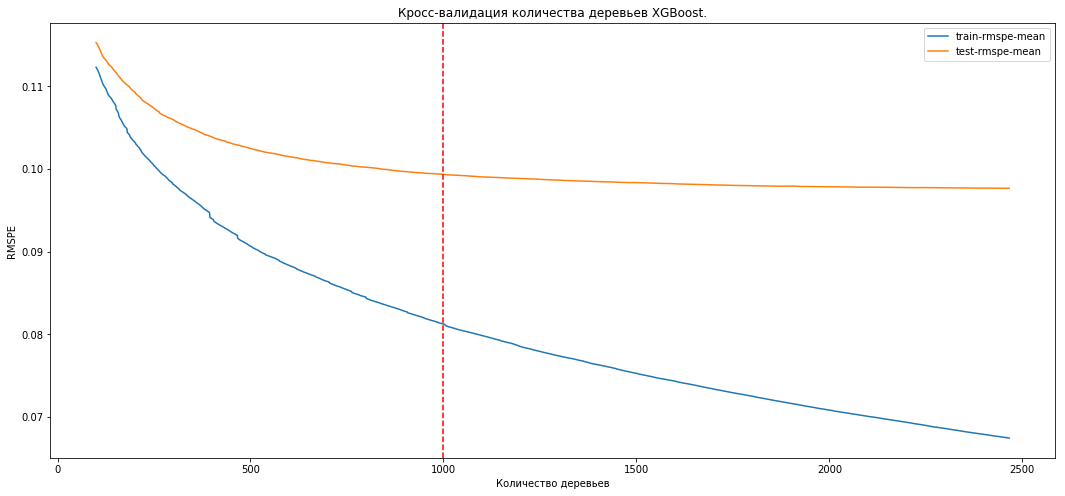

In [158]:
plt.figure(figsize=(18, 8))
cv_xgb["train-rmspe-mean"][100:].plot()
cv_xgb["test-rmspe-mean"][100:].plot()
plt.axvline(1000, color="r", linestyle="--")
plt.title("Кросс-валидация количества деревьев XGBoost.")
plt.xlabel("Количество деревьев")
plt.ylabel("RMSPE")
plt.legend()
plt.show()

Дальнейший подбор гипер-параметров. Снова итеративно подбирались, а затем фиксировались параметры ансамбля, деревьев, регуляризаторы.

In [379]:
model = xgb.XGBRegressor(n_estimators=1000, n_jobs=6, seed=42)

param_grid = {"max_depth" : [12], #[6, 10, 12],
              "learning_rate": [0.01], #[0.01, 0.1],
              "min_child_weight": [1], #[1, 2], #[0.01, 0.1],
              "gamma": [0], #[0, 0.1],
              "subsample": [0.8], #[0.8, 1],
              "colsample_bytree": [0.7], #[0.7, 1],
              "reg_alpha": [0], #[0, 0.1, 0.2, 0.5],
              "reg_lambda": [10] #[10, 20, 100] #[0.5, 1, 2, 10]
             }

X_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1][features_log].values
y_cv = df_train.sort_values("Date").loc[df_train["Open"] == 1]["LogSales"].values

splitter = TimeSeriesSplit(n_splits=3).split(X_cv)
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring=_score_rmspe, cv=splitter, verbose=3)
gs.fit(X_cv, y_cv)
gs.grid_scores_

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=10, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=10, subsample=0.8, score=-0.1671900128714855, total= 1.8min
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=10, subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=10, subsample=0.8, score=-0.12263710578583109, total= 4.1min
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=10, subsample=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.2min remaining:    0.0s


[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=10, subsample=0.8, score=-0.13586419281657042, total= 6.9min
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=20, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=20, subsample=0.8, score=-0.16707672206932786, total= 1.7min
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=20, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=20, subsample=0.8, score=-0.12316061120850333, total= 4.0min
[CV] colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=1, reg_alpha=0, reg_lambda=20, subsample=0.8 
[CV]  colsample_bytree=0.7, gamma=0, learning_rate=0.01, max_depth=12, mi

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 39.1min finished
D:\Programs\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: -0.14190, std: 0.01868, params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 12, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.8},
 mean: -0.14206, std: 0.01844, params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 12, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 20, 'subsample': 0.8},
 mean: -0.14345, std: 0.01809, params: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 12, 'min_child_weight': 1, 'reg_alpha': 0, 'reg_lambda': 100, 'subsample': 0.8}]

In [380]:
gs.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 12,
 'min_child_weight': 1,
 'reg_alpha': 0,
 'reg_lambda': 10,
 'subsample': 0.8}

In [209]:
def apply_xgb(features, num_round=1000):
    X_train, X_val, y_train, y_val = train_test_split(df_train.loc[df_train["Open"] == 1][features],
                                                        df_train.loc[df_train["Open"] == 1][["LogSales"]],
                                                        test_size=0.1, random_state=42)
    
    dtrain = xgb.DMatrix(X_train, y_train)
    dval = xgb.DMatrix(X_val, y_val)
    num_round = num_round
    evallist = [(dtrain, "train"), (dval, "val")]
    
    param = {"max_depth": 12,
             "eta": 0.01,
             "gamma": 0,
             "alpha": 0,
             "lambda": 10,
             "subsample": 0.8,
             "colsample_bytree": 0.7,
             "min_child_weight": 1,
             "silent": 1, 
             "objective": "reg:linear",
             "nthread": 6,
             "seed": 42}    

    reg_xgb = xgb.train(param, dtrain, num_round, evallist, feval=rmspe_metric_xgb, 
                        verbose_eval=250, early_stopping_rounds=250)
    
    return reg_xgb

def predict_xgb(features):
    X_test = df_test[features]
    dtest = xgb.DMatrix(X_test)
    return np.expm1(reg_xgb.predict(dtest))

In [210]:
reg_xgb = apply_xgb(features_log, 1000)
y_hat_xgb = predict_xgb(features_log)
make_submission(y_hat_xgb, "submission_XGB.csv")

[0]	train-rmse:8.18708	val-rmse:8.18883	train-rmspe:0.999865	val-rmspe:0.999865
Multiple eval metrics have been passed: 'val-rmspe' will be used for early stopping.

Will train until val-rmspe hasn't improved in 250 rounds.
[250]	train-rmse:0.679569	val-rmse:0.680336	train-rmspe:0.486334	val-rmspe:0.486523
[500]	train-rmse:0.11989	val-rmse:0.122176	train-rmspe:0.118748	val-rmspe:0.11924
[750]	train-rmse:0.09396	val-rmse:0.098387	train-rmspe:0.101113	val-rmspe:0.104092
[999]	train-rmse:0.087234	val-rmse:0.093369	train-rmspe:0.094438	val-rmspe:0.099648


Качество при применении XGBoost: Private RMSPE: 0.12056, Public: 0.10954. По важности признаков здесь на первое место вышли тренды временных рядов, затем день года и номер магазина.

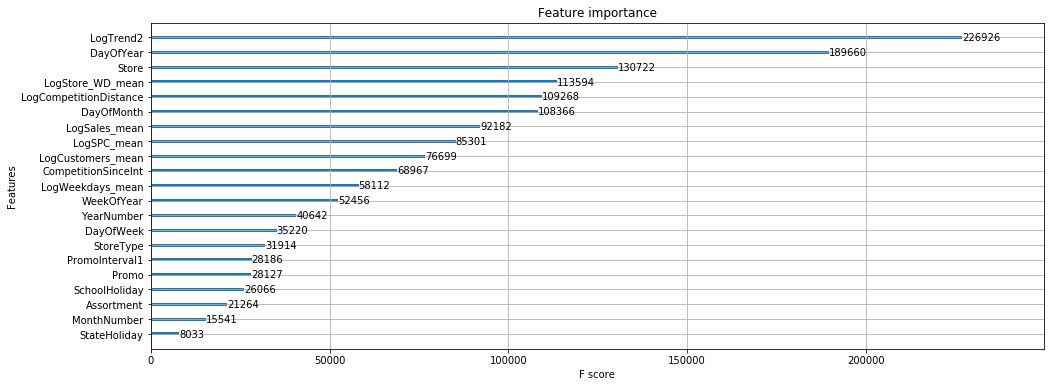

In [170]:
fig, ax = plt.subplots(figsize=(16, 6))
xgb.plot_importance(reg_xgb, ax)
plt.show()

Усреднение выходов RandomForest и XGBoost.

In [214]:
make_submission(np.mean([y_hat_rf, y_hat_xgb], axis=0), "submission_RF-XGB.csv")

В итоге удалось добиться точности Private RMSPE: 0.11957, Public: 0.10862. В дальнейшем, возможно, привело бы к улучшению результата более детальное исследование временного ряда каждого магазина и построения на них специализированных моделей. Также, можно попытаться кластеризовать магазины по "похожести" динамики продаж, путем транспонирования сводной таблицы временных рядов (каждый день - признак), понижения размерности и поиску близких элементов. Другим возможным улучшением представляется поиск дополнительных данных, как, например, фактическое расположение магазинов, тип населенного пункта, средний доход населения в этой местности, изменения погоды, экологическая и эпидемиологическая обстановка (магазины являются аптеками) и др.